<a href="https://colab.research.google.com/github/LSDtopotools/lsdtt_notebooks/blob/master/lsdtopotools/drainage_extraction_with_lsdtopotools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drainage area extraction

Last edited by Simon M Mudd 08/12/2022

In this notebook we will extract and plot some drainage areas. We will compare plotting using `lsdviztools` and `cartopy`. `cartopy` alongside `rasterio` is more felxible: there are general mapping tools. `lsdviztools` is a package built by the authors of *lsdtopotools* that is specifically for producing publication ready figure for specific studies. The documentation is much better for `cartopy` and `rasterio`. 

But first, we need to perform a drainage extraction from some test data. We are going to use a small lidar dataset. 

## Stuff we need to do if you are in colab (not required in the lsdtopotools pytools container)

**If you are in the `docker_lsdtt_pytools` docker container, you do not need to do any of this. 
The following is for executing this code in the google colab environment only.**

If you are in the docker container you can skip to the **Add some necessary packages** section. 

First we install `lsdviztools`. 

Note that if we install `condacolab` first the `lsdviztools` installation fails. 

In [ ]:
!pip install lsdviztools

Now we need to install lsdtopotools. We do this using something called `condacolab`. 

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Now install `lsdtopotools`. The `&> /dev/null` bit just stops a bunch of rubbish being printed to the screen.

In [ ]:
!mamba install lsdtopotools &> /dev/null

## Add some necessary packages

First check the version of lsdviztools

In [1]:
import lsdviztools
lsdviztools.__version__

'0.4.9'

In [2]:
import lsdviztools.lsdmapwrappers as lsdmw
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio

### Get the example data

The example data is an 18 Mb topographic dataset which you need to download:

In [ ]:
# Get the data from github
import urllib
urllib.request.urlretrieve("https://raw.githubusercontent.com/LSDtopotools/ExampleTopoDatasets/master/ChannelExtractionData/Guadalupe_1m/Guadalupe_DEM.hdr", "Guadalupe_DEM.hdr")
urllib.request.urlretrieve("https://raw.githubusercontent.com/LSDtopotools/ExampleTopoDatasets/master/ChannelExtractionData/Guadalupe_1m/Guadalupe_DEM.bil", "Guadalupe_DEM.bil")

Lets make sure that file (`Guadalupe_DEM.bil` and its header) have been downloaded:

In [3]:
!ls

CRN_analysis.ipynb
Diablo_COP30.tif
Diablo_COP30_UTM.bil
Diablo_COP30_UTM.bil.aux.xml
Diablo_COP30_UTM.hdr
Diablo_COP30_UTM.tif
Diablo_COP30_UTM_CURV.bil
Diablo_COP30_UTM_CURV.bil.aux.xml
Diablo_COP30_UTM_CURV.hdr
Diablo_COP30_UTM_PROFCURV.bil
Diablo_COP30_UTM_PROFCURV.hdr
Diablo_COP30_UTM_SLOPE.bil
Diablo_COP30_UTM_SLOPE.bil.aux.xml
Diablo_COP30_UTM_SLOPE.hdr
Diablo_COP30_UTM_dinf_area.bil
Diablo_COP30_UTM_dinf_area.hdr
Diablo_COP30_UTM_drape.png
Diablo_COP30_UTM_hillshade.png
Diablo_COP30_UTM_hs.bil
Diablo_COP30_UTM_hs.bil.aux.xml
Diablo_COP30_UTM_hs.hdr
Diablo_COP30_UTM_ingestedParam.param
Guadalupe_DEM.bil
Guadalupe_DEM.hdr
Guadalupe_DEM_MD_area.bil
Guadalupe_DEM_MD_area.hdr
Guadalupe_DEM_d8_area.bil
Guadalupe_DEM_d8_area.hdr
Guadalupe_DEM_dinf_area.bil
Guadalupe_DEM_dinf_area.bil.aux.xml
Guadalupe_DEM_dinf_area.hdr
Guadalupe_DEM_drape.png
Guadalupe_DEM_hs.bil
Guadalupe_DEM_hs.bil.aux.xml
Guadalupe_DEM_hs.hdr
Guadalupe_DEM_ingestedParam.param
SB_SRTMGL1.tif
SB_SRTMGL1_UTM.bil
SB_SR

## Extract the drainage area using a variety of methods

The below call to *lsdtt-basic-metrics* asks for a d8, a d-infinity, and a multidirection flow accumulation rasters.

In [ ]:
lsdtt_parameters = {"write_hillshade" : "true",
                    "print_d8_drainage_area_raster" : "true",
                    "print_dinf_drainage_area_raster" : "true",
                    "print_MD_drainage_area_raster" : "true"}
r_prefix = "Guadalupe_DEM"
w_prefix = "Guadalupe_DEM"
lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool = "lsdtt-basic-metrics", 
                                 read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

We can look at the files we generated using an `ls` call to the underlying file system (we access the underlying system with the symbol `!`:

In [ ]:
!ls

You should see several rasters with `_area` in the filename as well as an indicator of what method was used. Lets have a look at these data. 

## Plotting the data with imshow 

First we jut plot the draiange are with imshow and rasterio with no real adjustments to the plotting:

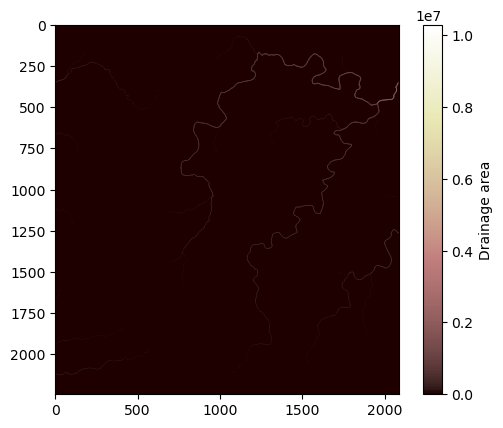

In [4]:
%matplotlib inline
import rasterio
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
src = rasterio.open('Guadalupe_DEM_d8_area.bil')
cs = ax.imshow(src.read(1), cmap='pink')

cbar = fig.colorbar(cs,label="Drainage area")

There are some rather glaring problems with this plot:
    
* You can't see anything on the plot (if you really squint you can see a single channel.
* The axes labels don't retain spatial information (imshow plots axes with pixel numbers and doesn't know anything about geography).

We will fix there problems one at a time.

### Fix the problem with not being able to see the channels

The problem with not being able to see the channels is becasue drainage area varies over several orders of magnitude. Whenever you have a dataset that varies over several orders of magnitude and you want to plot the data your best option is to use a logarithmic scale. So I will do that below:

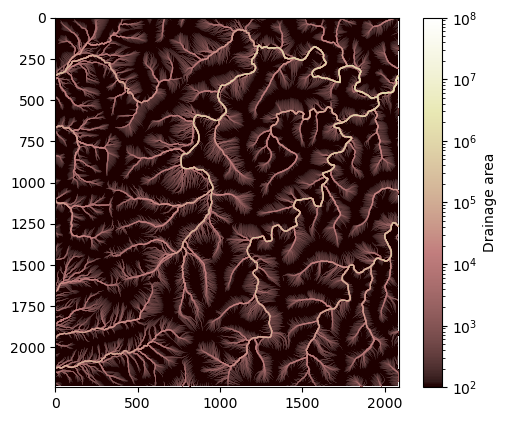

In [5]:
%matplotlib inline
import rasterio
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
src = rasterio.open('Guadalupe_DEM_d8_area.bil')
cs = ax.imshow(src.read(1), cmap='pink', norm=LogNorm(vmin=100, vmax=100000000))

cbar = fig.colorbar(cs,label="Drainage area")
#cbar.ax.minorticks_off()  # Uncomment this if the colourbar is too cluttered

That looks better! Now for the next problem: we need some spatial coordinates. 
To do this we need to get geospatial information from the raster. Rasterio is great for this purpose. 

### Getting geospatial information from your DEM using rasterio

In [6]:
import cartopy as cp
import cartopy.crs as ccrs

First we get the extent of the DEM. We need this for plotting later

In [7]:
bounds = src.bounds
Extent = [bounds.left,bounds.right,bounds.bottom,bounds.top]

Then we get the coordinate reference system (`crs`). 

*LSDTopoTools* uses the UTM coordinate system as a default. You need to use the UTM zone for plotting later. So you will need to just read the zone (the last two digits in the output from the next command) for the steps thereafter.

In [8]:
src.crs

CRS.from_epsg(32613)

Okay, so the last two digits are `13` so in the below code there are a number of instances of calls to `.UTM` and we need to put `13` in each of these calls. If you had a different dataset you would use that dataset's UTM zone. 

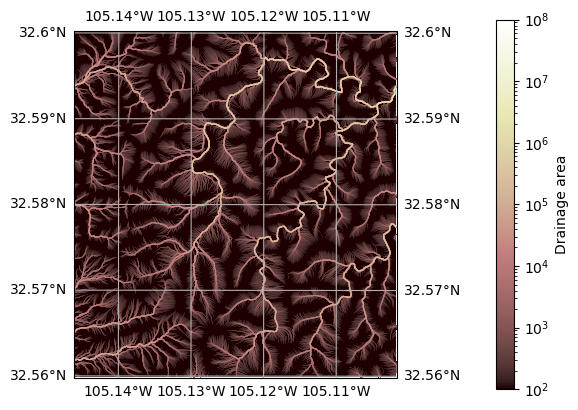

In [9]:
fig = plt.figure()

# Set the projection to UTM zone 13
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(13))

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(13))
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
cs = ax.imshow(src.read(1), cmap='pink', norm=LogNorm(vmin=100, vmax=100000000),
               extent=Extent, transform=ccrs.UTM(13), origin="upper")

# Add some padding to the colourbar so it doesn't overlap with the axis labels using pad command
cbar = fig.colorbar(cs,label="Drainage area",pad=0.2)
#fig.savefig("test.png", dpi=300)

Okay, now we have a plot with spatial coordinates! Thanks `cartopy`! We will try to make the image nicer by draping the drainage area over a hillshade. 

### Fixing a washed out hillshade 

Before we do the final part I need to show you a potential problem with the hillshade and using `imshow`. 
Let's plot the hillshade data using the same method as last time:

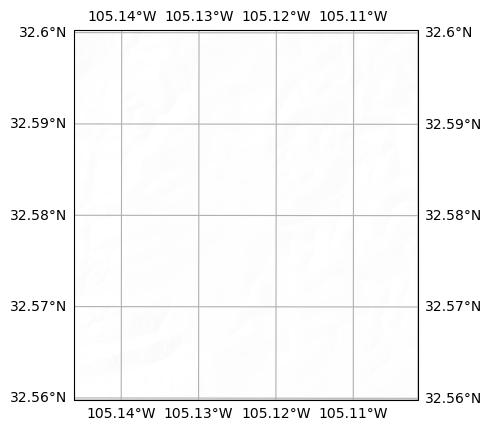

In [10]:
# First load the hillshade with rasterio
DEMHSdata = rasterio.open('Guadalupe_DEM_HS.bil')

# Now plot. We remove the code with the logarithmic scale for the hillshde image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(13))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(13))
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
cs = ax.imshow(DEMHSdata.read(1), cmap='gray', 
               extent=Extent, transform=ccrs.UTM(13), origin="upper")

Hey, what gives? That doesn't look like a hillshade!!

The problem is that there is some nodata in this raster, and the nodata value is -9999. The hillshade data has values between 0 and 256 so these -9999 values wash out the colour scale. You can fix this in two ways. 

One is you can plot the colourbar only over a range, using the colour limits that are denoted using `vmin` and `vmax`. Like this:

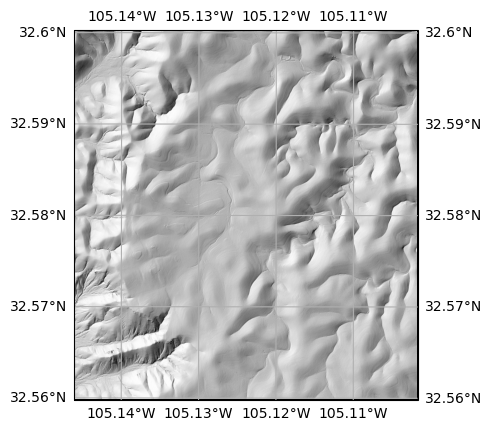

In [11]:
# Now plot. We remove the code with the logarithmic scale for the hillshde image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(13))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(13))
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
cs = ax.imshow(DEMHSdata.read(1), cmap='gray', vmin=0, vmax=256,
               extent=Extent, transform=ccrs.UTM(13), origin="upper")

Alternatively you could load the data as an array and use `numpy` array manipulation tools to get rid of those -9999 values. 

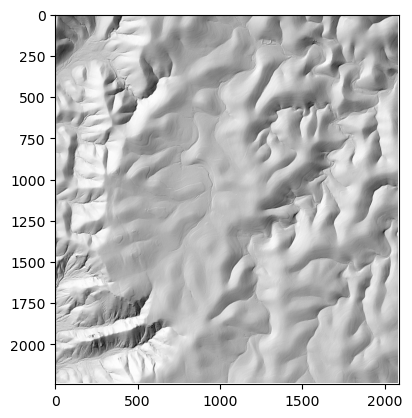

In [12]:
import numpy as np
DEMHSdata = rasterio.open('Guadalupe_DEM_HS.bil')
arrayHS = DEMHSdata.read(1)
arrayHS[arrayHS==-9999]=np.nan
plt.imshow(arrayHS,cmap="gray")

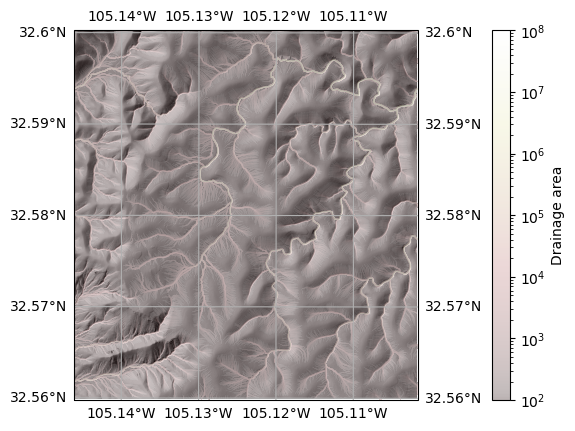

In [13]:
DEMHSdata = rasterio.open('Guadalupe_DEM_HS.bil')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(13))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(13))
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
ax.imshow(arrayHS, cmap='gray',
              extent=Extent, transform=ccrs.UTM(13), origin="upper",
               alpha = 1)
cs = ax.imshow(src.read(1), cmap='pink', norm=LogNorm(vmin=100, vmax=100000000),
               extent=Extent, transform=ccrs.UTM(13), origin="upper",
               zorder=2,alpha=0.3)
cbar = fig.colorbar(cs,label="Drainage area",pad=0.15)

## Okay, lets try the same thing with lsdviztools

`lsdviztools` is less flexible than using cartopy and matplotlib: it is built on top of those two packages to make images specifically for publication and if you wanted to make changes you would need to go into the source code. But for specific maps we think the formatting is rather nice.

In [15]:
### Plot the topographic gradient  
Base_file = "Guadalupe_DEM"
r_prefix = "Guadalupe_DEM"
Drape_prefix = r_prefix+"_dinf_area"
DataDirectory = "./"
this_area_img = lsdmw.SimpleDrape(DataDirectory,Base_file,Drape_prefix, cmap="pink", 
                                       cbar_label = "Drainage area",
                                       cbar_loc = "bottom",
                                       drape_cnorm = "LogNorm",
                                       colour_min_max = [1000,10000000],
                                       save_fig=True, size_format="ESURF",dpi=600)

Your colourbar will be located: bottom
xsize: 2084 and y size: 2243
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32613
EPSG:32613
The EPSGString is: EPSG:32613
minimum values are x: 486286.0 and y: 3602493.0
I made the ticks.
x labels are: 
['487', '487', '488', '489', '490']
x locations are:
[487000.0, 487800.0, 488600.0, 489400.0, 490200.0]
y labels are: 
['3603', '3604', '3604', '3605', '3606']
y locations are:
[3603200.0, 3604000.0, 3604800.0, 3605600.0, 3606400.0]
This colourmap is: gray
The number of axes are: 1
Axes(0,0;1x1)
Axes(0,0;1x1)
N axes are: 1
Axes(0,0;1x1)


/LSDTopoTools/python_projects/lsdviztools/lsdviztools/lsdmapfigure/plottingraster.py:453: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.tick_x_labels)
/LSDTopoTools/python_projects/lsdviztools/lsdviztools/lsdmapfigure/plottingraster.py:454: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.tick_y_labels)


xsize: 2084 and y size: 2243
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32613
EPSG:32613
The EPSGString is: EPSG:32613
I am going to use the normalisation LogNorm
I am using the full range of values in the raster.
custom min and max are:
1000
10000000
I am setting customisable colourbar minimum and maximum values: 1000,10000000
The number of axes are: 2
The aspect ratio is: 0.9291127953633527
I need to adjust the spacing of the colourbar.
The cbar characters are: 0 and the cbar text width is: 0.4
I am placing the colourbar on the bottom
cbar_left: 0.8500000000000001 map left: 0.8500000000000001
cbar_bottom: 0.6000000000000001 map bottom: 1.35
The figure size is: 
[4.92126, 5.716620047984645]
Map axes are:
[0.1727199944729602, 0.2361535293002258, 0.7866400068275198, 0.7288607626552962]
cbar_axes are:
[0.1727199944729602, 0.1049571241334337, 0.7866400068275198, 0.03498570804447789]
Number of axes are: 2


findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.


I'm returning:
./Guadalupe_DEM_drape.png


<Figure size 640x480 with 0 Axes>

Hey? Where is my image??? Because we used `save_fig=True`, the image is not displayed but rather printed to file. So we can look at it with a call to `display`:

./Guadalupe_DEM_drape.png


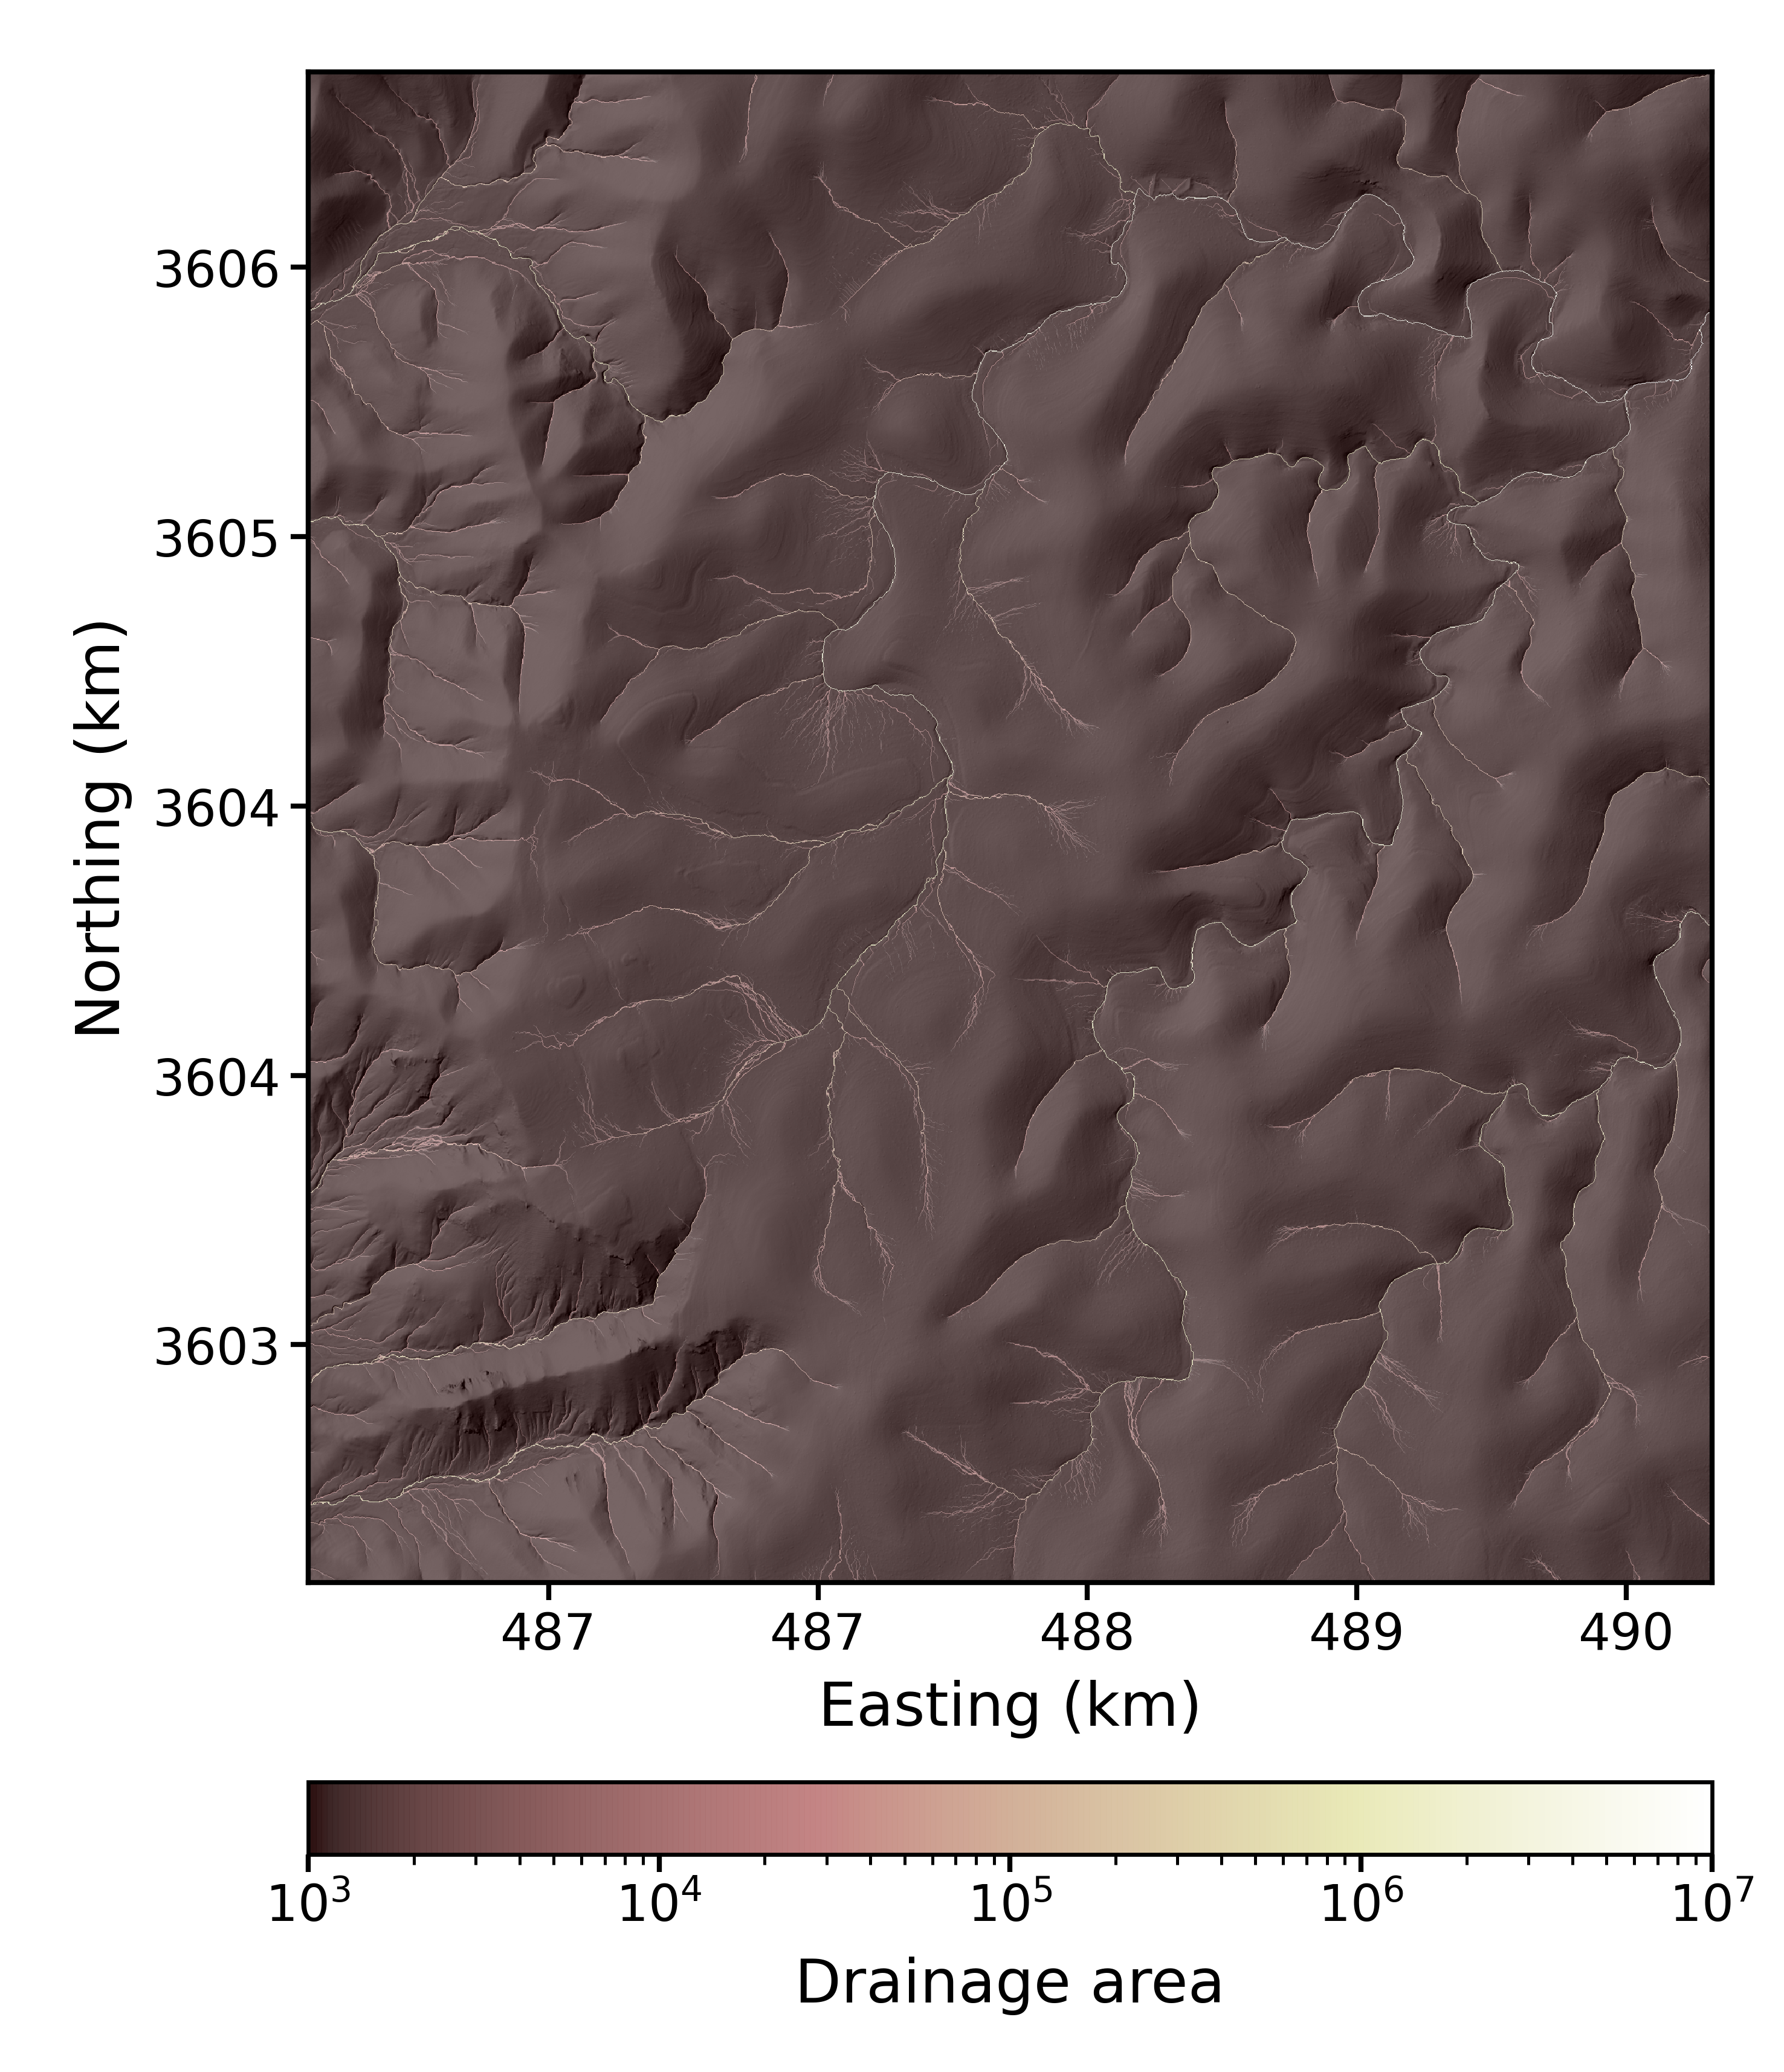

In [16]:
print(this_area_img)
from IPython.display import display, Image
display(Image(filename=this_area_img, width=600))

Congratulations! You should now have an idea about how to both extract and plot drainage area using *LSDTopoTools*